In [26]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import euclidean_distances
import SemisupFns as SF
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import MiscFcns as MF
import seaborn as sns
import scipy.stats as ss
%matplotlib inline

In [4]:
#Reading feature vector 
X = pd.read_csv('./amp_ad_rna_seq_feature_set.csv')

#Dropping GeneID column 
GeneId = X['GeneID']
X = X.drop(['GeneID'], axis = 1)
X.head()

#Reading response vector 
Y = pd.read_excel('./ResponseVec_040318.xlsx')
Y = Y.drop(['GeneID'], axis = 1)
Y.head()

,Y
0,0
1,0
2,0
3,0
4,0


In [5]:
#Performing dimensionality reduction using PCA to 2 dimensions 
pca = PCA(n_components=20)
X_normed = X.values / X.values.max(axis=0)
pca.fit(X_normed)
X_pca = pca.fit_transform(X_normed)

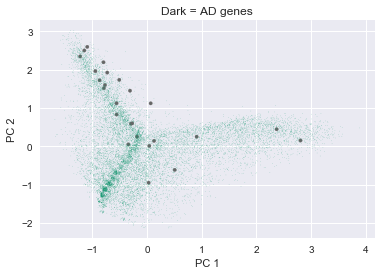

In [6]:
#Coloring the known AD related genes differently 
plt.scatter(X_pca[:,0],X_pca[:,1], c = Y.values , s =(Y.values+.5)**6, cmap = 'Dark2')
plt.title('Dark = AD genes')
plt.xlabel('PC 1') 
plt.ylabel('PC 2')

In [7]:
#Balancing classes for better classification performance 
tmp = SF.BalanceClasses(X_normed + 0.0 ,Y.values + 0.0)
X_train, y_train = tmp['X'],tmp['y']

In [ ]:
C_best = SF.GetBestModel(X_train,y_train,pen='l2')
print C_best

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [8]:
D = SF.IterativeTraining(X_normed + 0.0, Y.values + 0.0 ,C = 1e4,pen='l2',Iter = 10, 
                      Thresh = 0.9)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


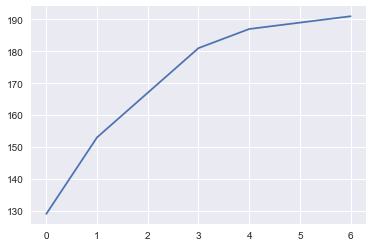

In [9]:
plt.plot(D['NoPos'])

In [10]:
def CrossValScore(Mdl,X,y):
    c, r = y.shape
    y = y.reshape(c,)
    Prec = cross_val_score(Mdl, X, y, cv=10, scoring='precision')
    Rec = cross_val_score(Mdl, X, y, cv=10, scoring='recall')
    AUC = cross_val_score(Mdl, X, y, cv=10, scoring='roc_auc')
    
    return {'Prec':Prec, 'Rec':Rec, 'AUC':AUC}

In [11]:
Scores = CrossValScore(D['LR'],X_train + 0.0,y_train + 0.0)

In [12]:
Y_pred = D['LR'].predict(X_normed)

In [13]:
Scores

{'AUC': array([0.99647977, 0.99637123, 0.99320782, 0.99331173, 0.99448098,
        0.99420255, 0.99359083, 0.99281511, 0.99470463, 0.99844664]),
 'Prec': array([0.9796334 , 0.98565574, 0.97302765, 0.97434166, 0.97764228,
        0.96908602, 0.9749831 , 0.97300945, 0.98497268, 0.98228883]),
 'Rec': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [14]:
#fit regular logistic regression 
LR = LogisticRegression(penalty = 'l2', solver = 'saga', C = 1e4)
LR.fit(X_train,y_train)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [15]:
Scores2 = CrossValScore(LR,X_train + 0.0,y_train + 0.0)
Scores2

{'AUC': array([0.99647977, 0.99637123, 0.99320782, 0.99331173, 0.99448098,
        0.99417466, 0.99361824, 0.99281511, 0.99470463, 0.99844664]),
 'Prec': array([0.98029891, 0.98565574, 0.97302765, 0.97434166, 0.97764228,
        0.96908602, 0.9749831 , 0.97300945, 0.98497268, 0.98228883]),
 'Rec': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [16]:
sum(D['LR'].predict(X_normed) == LR.predict(X_normed))

14293

In [17]:
Y1 = D['LR'].predict(X_normed)

Y2 = LR.predict(X_normed)

print(sum(Y1))
print(sum(Y2))

print(sum(Y1*Y2))

Y1 = D['LR'].predict_proba(X_normed)
Y1 = Y1[:,1]

Y2 = LR.predict_proba(X_normed)
Y2 = Y2[:,1]

320.0
297.0
231.0


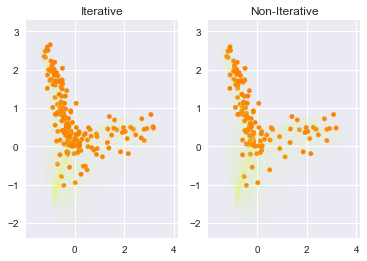

In [18]:
#Coloring PCs based on predicted probabilities sized by known AD genes (for iterative model)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.scatter(X_pca[:,0],X_pca[:,1], c = Y1 , s =(20*(Y1>0.9)+.01), cmap = 'Wistia')
ax1.set_title('Iterative')

ax2.scatter(X_pca[:,0],X_pca[:,1], c = Y2 , s =(20*(Y2>0.9)+.01), cmap = 'Wistia')
ax2.set_title('Non-Iterative')


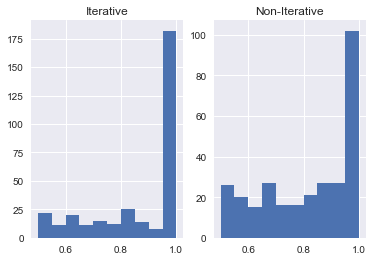

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

ax1.hist(Y1[Y1>0.5])
ax1.set_title('Iterative')
ax2.hist(Y2[Y2>0.5])
ax2.set_title('Non-Iterative')

In [44]:
#Getting list of genes which have SNPs according to IGAP_stage1
cnt = 0 
GeneNames = []
MinPval = []
AvgLogPval = []
with open("E:/SageDocs/AMP-AD_Network_Analysis/IGAP_files/IGAP_geneAnalysis.genes.raw") as f:
    for line in f:
        if cnt <= 1:
            cnt+=1 
            continue
            
        cnt += 1
        temp = line.split(' ')

        if len(temp)>9:
            GeneNames += [temp[0]]
            temp = map(float,temp[9:])
            MinPval += [min(temp)]
            AvgLogPval += [np.mean(np.log10(temp))]
        

In [45]:
#Getting the ENSEMBL ID's of the predicted regulator genes
bla = np.argwhere(Y1>0.9)
GenePred = list(GeneId[bla[:,0]])

#Converting to Gene Symbols 
GenePred = MF.ConvertToSymb(GenePred)

querying 1-190...done.
Finished.
3 input query terms found dup hits:
	[(u'ENSG00000160209', 2), (u'ENSG00000076928', 2), (u'ENSG00000159216', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [46]:
IGAP_genes = pd.DataFrame(data = {'Genes':GeneNames,'Pval':MinPval,'MeanPval':AvgLogPval})
IGAP_genes.head()

,Genes,MeanPval,Pval
0,ISG15,-0.148666,0.710123
1,AGRN,-0.142638,0.679699
2,RNF223,-0.381026,0.340268
3,C1orf159,-0.833337,0.091718
4,TTLL10,-2.191774,0.003411


In [47]:
def PredGenesPval(IGAP_genes,GenePred):
    Int = list(set(GeneNames).intersection(GenePred))
    
    G = [] 
    P = []
    Pmean = []
    
    for i in range(len(Int)):
        In = IGAP_genes['Genes'][IGAP_genes['Genes']==Int[i]].index[0]
        G += [IGAP_genes['Genes'][In]]
        P += [IGAP_genes['Pval'][In]]
        Pmean += [IGAP_genes['MeanPval'][In]]

        
    PredGenes_pval = pd.DataFrame(data = {'GeneSymb':G,'Pval':P,'MeanPval':Pmean})
    return PredGenes_pval
    

In [48]:
#Getting p-values of predicted genes 
PredGenes_pval = PredGenesPval(IGAP_genes,GenePred)

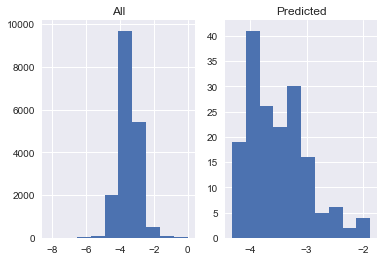

In [49]:
#Comparing min p-values of all genes on IGAP stage 1 with those from our prediction 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.hist(np.log10(IGAP_genes['Pval']))
ax1.set_title('All')
ax2.hist(np.log10(PredGenes_pval['Pval']))
ax2.set_title('Predicted')

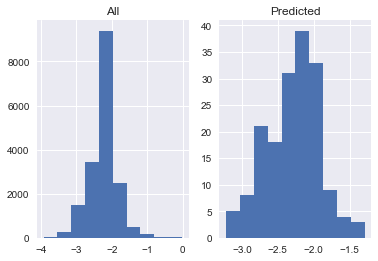

In [50]:
#Comparing average p-values of all genes on IGAP stage 1 with those from our prediction 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.hist((IGAP_genes['MeanPval']))
ax1.set_title('All')
ax2.hist((PredGenes_pval['MeanPval']))
ax2.set_title('Predicted')

In [51]:
#Get t-test value 1
temp = ss.ttest_ind(np.log10(IGAP_genes['Pval']),np.log10(PredGenes_pval['Pval']))
print temp

Ttest_indResult(statistic=0.7096355017181105, pvalue=0.477939399593047)


In [52]:
#Get t-test value 1
temp = ss.ttest_ind((IGAP_genes['MeanPval']),(PredGenes_pval['MeanPval']))
print temp

Ttest_indResult(statistic=2.0722890166209105, pvalue=0.038252713178450304)
